# Logistic Regreesion and Softmax Regression

`Author: YUAN Yanzhe`

- this notebook contains: 
  - logistic regression with simple data (binary classification)
  - softmax from scratch
  - softmax on Iris dataset
  - softmax on image dataset (MNIST)
  - visualization on generated data
 

## LR with simple data

- notes:
  - logistic回归属于分类任务，二分类任务
  - logistic回归采用交叉熵损失函数
    - 采用binary cross entropy  
  - softmax回归即多标签回归，适用于多分类任务，广义上softmax回归涵盖logistic回归。
    - softmax采用nn.CrossEntropyLoss(), 包含softmax在里面: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=nn%20crossentropyloss#torch.nn.CrossEntropyLoss
      - torch.nn中的交叉熵为nn.LogSoftmax()+nn.NLLLoss()，前者为算出标签对应输入中的某一类的log形式的softmax（log后值域为负无穷到0）得分，后者为将该得分与label相加，求平均，取相反数（方便更新）。

In [7]:
# import packages
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import init

import random
import numpy
import d2lzh_pytorch as d2dl

In [8]:
# Hyperparameter Definition
num_features = 2
num_examples = 4
num_epochs = 20

# Obtain Data
# since it is a classfication task, we need generate fake data from two distributions
features = torch.Tensor([[0.6,0.3], [1.0,2.5], [3.5,3.4], [4.0,5.3]])
labels = torch.Tensor([[0.], [0.], [1.], [1.]])
print(features.size(),labels.size())

# Load Data
# in PyTorch 0.4 Variable is disgarded, torch.Tensor combines the original function on Variable
X = features
y = labels

# Define Model
class Logistic_Regression_Model(nn.Module):
    def __init__(self, num_features):
        super(Logistic_Regression_Model, self).__init__()
        self.linear = nn.Linear(num_features,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.sigmoid(self.linear(x))
        return y

# instance the network
net = Logistic_Regression_Model(num_features)

# check model parameters
for param in net.parameters():
    print(param)

# define loss function
# BCE=Binary Cross Entropy, no Sigmoid inside so need to add a Sigmoid layer in the NN
loss_func = nn.BCELoss()  

# define the optimizator

optimizor = optim.SGD(net.parameters(),lr=0.03, momentum=0.9)

# Training process
# initialize the parameters
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

# train
for epoch in range(num_epochs):
    output = net(X)
    #print(output)
    loss = loss_func(output,y.view(-1,1))  # to make y a column (no need in DataLoader())
    mask = output.ge(0.5).float()
    correct = (mask == y.view(-1,1)).sum()
    # print(correct)
    accuracy = correct / X.size(0)
        
    optimizor.zero_grad()
    loss.backward()
    optimizor.step()
    if (epoch+1) % 1 == 0:
        print('epoch {} loss is {:.4f} accuracy is {:.4f}\n'.format(epoch+1 , loss.item(), accuracy))

        


torch.Size([4, 2]) torch.Size([4, 1])
Parameter containing:
tensor([[ 0.4647, -0.6698]], requires_grad=True)
Parameter containing:
tensor([0.4867], requires_grad=True)
epoch 1 loss is 0.6798 accuracy is 0.5000

epoch 2 loss is 0.6528 accuracy is 0.5000

epoch 3 loss is 0.6145 accuracy is 0.5000

epoch 4 loss is 0.5820 accuracy is 0.5000

epoch 5 loss is 0.5636 accuracy is 0.5000

epoch 6 loss is 0.5579 accuracy is 0.5000

epoch 7 loss is 0.5591 accuracy is 0.5000

epoch 8 loss is 0.5613 accuracy is 0.5000

epoch 9 loss is 0.5607 accuracy is 0.5000

epoch 10 loss is 0.5554 accuracy is 0.5000

epoch 11 loss is 0.5451 accuracy is 0.5000

epoch 12 loss is 0.5303 accuracy is 0.5000

epoch 13 loss is 0.5124 accuracy is 0.5000

epoch 14 loss is 0.4932 accuracy is 0.5000

epoch 15 loss is 0.4745 accuracy is 0.7500

epoch 16 loss is 0.4581 accuracy is 0.7500

epoch 17 loss is 0.4449 accuracy is 0.7500

epoch 18 loss is 0.4350 accuracy is 0.7500

epoch 19 loss is 0.4274 accuracy is 1.0000

epoch

## Softmax from scratch

- 一些细节：
  - 原始datasets.MNIST的数据是(batch,1,28,28)的形式
    - 在imshow的时候，image的size应转换为(28,28,1)
    - 在输入模型的时候，为了贴合W，应该转换为(-1,28\*28)的形式即(-1,28\*28)
  - 这里由于是手写softmax的各个环节，所以训练时loss用了sum，一般在torch的crossentropyloss中应该是mean，所以计算total_loss的时候需要注意。

In [9]:
import torch
from torch import nn
from torch.utils import data as Data 
from torch import optim as optim
from torch.nn import init

import torchvision
from torchvision import transforms as transforms

import d2lzh_pytorch as d2dl

from matplotlib import pyplot as plt

60000
torch.Size([256, 1, 28, 28])
5


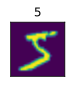

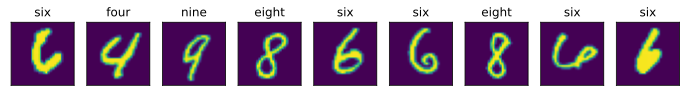

epoch: 1, loss:0.7117, train acc: 0.845, test acc: 0.888
epoch: 2, loss:0.4294, train acc: 0.887, test acc: 0.900
epoch: 3, loss:0.3838, train acc: 0.896, test acc: 0.906
epoch: 4, loss:0.3608, train acc: 0.901, test acc: 0.909
epoch: 5, loss:0.3461, train acc: 0.904, test acc: 0.912
epoch: 6, loss:0.3356, train acc: 0.907, test acc: 0.913
epoch: 7, loss:0.3277, train acc: 0.909, test acc: 0.914
epoch: 8, loss:0.3212, train acc: 0.910, test acc: 0.916
epoch: 9, loss:0.3161, train acc: 0.912, test acc: 0.916
epoch: 10, loss:0.3117, train acc: 0.913, test acc: 0.918


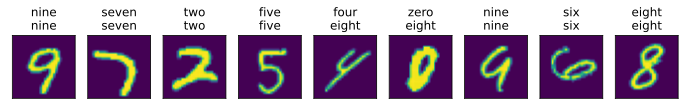

In [27]:
# Hyperparametes
batch_size = 256
num_features = 784
num_classes = 10
lr = 0.1
num_epochs = 10

# Obtain Data
train_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',train=True,\
                                        download=False,transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',train=False,\
                                        download=False,transform=transforms.ToTensor())
print(len(train_data))
#print(train_data[0])

# Load Data
train_data_iterator = Data.DataLoader(train_data,batch_size,shuffle=True)
test_data_iterator = Data.DataLoader(test_data,batch_size,shuffle=True)

# Visulize Data
image_exmp, label_exmp = train_data[0]
image_batch, label_batch = iter(train_data_iterator).next()
print(image_batch.size())
print(label_exmp)

def show_image(img, label):
    d2dl.use_svg_display() 
    plt.figure(figsize=(1, 1))
    plt.imshow(img.view(img.size(1),img.size(1),-1).numpy())
    plt.title(label)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.plot()

def get_label_name(labels):
    text_labels = ['zero', 'one', 'two', 'three', 'four',
                   'five', 'six', 'seven', 'eight', 'nine']
    return [text_labels[int(i)] for i in labels]

def show_multiple_image(images, labels):
    d2dl.use_svg_display() 
    _,figs = plt.subplots(1,len(images),figsize=(12,12))  # figure,axes=plt.subplots(), each axes can represent a subplot
    for fig,image,label in zip(figs,images,labels):
        fig.imshow(image.view(image.size(1),image.size(1),-1).numpy())
        fig.set_title(label)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

# show one images
show_image(image_exmp,label_exmp)

# can either use dataloader or datasets.MNIST to do visualization
#X,y = [], []
#for i in range(10):
#    X.append(train_data[i][0])
#    y.append(train_data[i][1])
#show_multiple_image(X,get_labels(y))

# show multiple images
show_multiple_image(image_batch[0:9],get_label_name(label_batch[0:9]))

# Define Model
# initialization
W = torch.tensor(np.random.normal(0,0.01,(num_features,num_classes)),dtype=torch.float32)
b = torch.zeros(num_classes, dtype=torch.float32)
W.requires_grad_(True)
b.requires_grad_(True)

def softmax(X):
    return torch.exp(X) / torch.exp(X).sum(dim=1,keepdim=True)

def model(X):  # there is a variable called net previously, so i name it model to distinguish
    return softmax(torch.mm(X.view(-1,num_features),W)+b)

def cross_entropy_loss(y_hat, y):
    return -torch.log(y_hat.gather(1,y.view(-1,1)))  # don't forget the view, y is originally a row

def accuracy(data_iter, net):
    correct = 0.0
    total = 0
    for X,y in data_iter:
        y_hat = net(X)
        correct += (torch.argmax(y_hat,1)==y).float().sum().item()  # don't forget the float()(oh maybe no need) and the item()
        total += X.size(0)
    return correct / total    
    
# Train Model
def train_model(net, train_iter, test_iter, loss_func, num_epochs, batch_size,optimizor=None,lr=None,params=None):
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, total = 0.0,0.0,0
        for X, y in train_iter:
            output = net(X)
            loss = loss_func(output,y).sum()  # no sum in the cross_entropy_loss(), so there should be one.
        
            if optimizor is not None:
                    optimizor.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            loss.backward()
            if optimizor is None:
                d2dl.sgd(params,lr,batch_size)
            else: 
                optimizor.step()
            
            train_loss_sum += loss.item()
            train_acc_sum += (output.argmax(1)==y).sum().item()
            total += y.shape[0]
    
        # Test Model
        test_acc = accuracy(test_iter, net)
        print('epoch: %d, loss:%.4f, train acc: %.3f, test acc: %.3f' %(epoch+1,train_loss_sum/total,train_acc_sum/total,test_acc))
                    
train_model(model, train_data_iterator, test_data_iterator, cross_entropy_loss, num_epochs, batch_size, params=[W, b], lr=lr)

# Predict
X, y = iter(test_data_iterator).next()

true_labels = get_label_name(y.numpy())
pred_labels = get_label_name(model(X).argmax(1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_multiple_image(X[0:9], titles[0:9])
    

## Softmax with MNIST dataset (image classification)

- 一些细节：
  - 关乎with torch.no_grad(): 可见https://www.zhihu.com/question/326044178
    - 简而言之，就是当不需要将算式加入计算图（autograd）的时候就可以加这一句减少存储空间。

In [20]:
import torch
from torch import nn
from torch.utils import data as Data 
from torch import optim as optim
from torch.nn import init

import torchvision
from torchvision import transforms as transforms

from matplotlib import pyplot as plt

In [21]:
# Hyperparameters
batch_size = 100
learning_rate = 0.001
num_epochs = 5
num_features = 784
num_classes = 10


# Obtain Data
train_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/', train=True,\
                                        transform=transforms.ToTensor(),download=True)

test_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/', train=False,\
                                        transform=transforms.ToTensor())

# Load Data
train_data_iterator = Data.DataLoader(train_data, batch_size, shuffle=True)
test_data_iterator = Data.DataLoader(test_data, batch_size, shuffle=True)

# Define Model
net = nn.Sequential()
net.add_module('linear',nn.Linear(num_features,num_classes))
print(net[0])

loss_func = nn.CrossEntropyLoss()
optimizor = optim.SGD(net.parameters(),lr=learning_rate)

# Train Model

# initial the parameters
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

print('start training......')
total_step = len(train_data_iterator)
for epoch in range(num_epochs):
    for step,(img,label) in enumerate(train_data_iterator):
        # reshape image to (batch_size, 28, 28)
        img = img.reshape(-1,28*28)
        
        output = net(img)
        loss = loss_func(output, label)
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
        
        # print intermediate results
        if (step+1) % 100 == 0: 
            print('Epoch: %d/%d, Step:%d/%d, CE_Loss: %f' %(epoch+1,num_epochs,step+1,total_step,loss.item()))
print('training done......')

# Test Model
print('start testing......')
with torch.no_grad():
    correct = 0
    total = 0
    for img,label in test_data_iterator:
        img = img.reshape(-1,28*28)
        
        output = net(img)
        total += img.size(0)
        _, predicted = torch.max(output,1)
        correct += (label==predicted).sum(0)
    print('total accuracy is: %f' %(100 * correct / total))



Linear(in_features=784, out_features=10, bias=True)
start training......
Epoch: 1/5, Step:100/600, CE_Loss: 2.198008
Epoch: 1/5, Step:200/600, CE_Loss: 2.120024
Epoch: 1/5, Step:300/600, CE_Loss: 2.005516
Epoch: 1/5, Step:400/600, CE_Loss: 1.946165
Epoch: 1/5, Step:500/600, CE_Loss: 1.875469
Epoch: 1/5, Step:600/600, CE_Loss: 1.762361
Epoch: 2/5, Step:100/600, CE_Loss: 1.737390
Epoch: 2/5, Step:200/600, CE_Loss: 1.672607
Epoch: 2/5, Step:300/600, CE_Loss: 1.637746
Epoch: 2/5, Step:400/600, CE_Loss: 1.565423
Epoch: 2/5, Step:500/600, CE_Loss: 1.479414
Epoch: 2/5, Step:600/600, CE_Loss: 1.460396
Epoch: 3/5, Step:100/600, CE_Loss: 1.422652
Epoch: 3/5, Step:200/600, CE_Loss: 1.380671
Epoch: 3/5, Step:300/600, CE_Loss: 1.346445
Epoch: 3/5, Step:400/600, CE_Loss: 1.240313
Epoch: 3/5, Step:500/600, CE_Loss: 1.262993
Epoch: 3/5, Step:600/600, CE_Loss: 1.284897
Epoch: 4/5, Step:100/600, CE_Loss: 1.236847
Epoch: 4/5, Step:200/600, CE_Loss: 1.164555
Epoch: 4/5, Step:300/600, CE_Loss: 1.217210
Epo

## Softmax Regression with Iris dataset

In [22]:
# import packages
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import init
from torch.utils import data as Data

import random
import numpy
import d2lzh_pytorch as d2dl

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [23]:
# Try with iris dataset, a 3-type classification task

# Hyperparameters
batch_size = 10
num_epochs = 50
learning_rate = 0.01

# Obtain Data
data = load_iris()
labels = data.target
features = data.data

# split into train and test data
features, features_test, labels, labels_test = train_test_split(features,labels,test_size=0.2,random_state=32)

num_features = len(data.feature_names)
num_examples = features.shape[0]
num_classes = len(np.unique(labels))
print('train:',num_features,num_examples,num_classes)

# Load Data
labels = torch.tensor(labels)
features = torch.Tensor(features)
labels_test = torch.tensor(labels_test)
features_test = torch.Tensor(features_test)
print(labels.dtype)

# train data batch_loader
train_dataset = Data.TensorDataset(features, labels)
train_data_iterator = Data.DataLoader(train_dataset, batch_size, shuffle=True)

# train data batch_loader
test_dataset = Data.TensorDataset(features, labels)
test_data_iterator = Data.DataLoader(test_dataset, batch_size, shuffle=True)

# Define Model
class logistic_regression(nn.Module):
    def __init__(self, num_features, num_classes):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(num_features, num_classes)
    def forward(self, x):
        y = self.linear(x)
        return y

net = logistic_regression(num_features,num_classes) 
print(net)
loss_func = nn.CrossEntropyLoss()  # softmax is built internally, so no need to write softmax layer.
optimizor = optim.SGD(net.parameters(),lr=learning_rate)

# Train Model

# initalize parameters
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

print('start training......')
for epoch in range(num_epochs):
    for X,y in train_data_iterator:
        output = net(X)
        #print(output.size())
        #print(y.view(-1,1).size())
        loss = loss_func(output, y)  
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
    print ('Epoch [%d/%d], CE_Loss: :%f' %(epoch+1, num_epochs, loss_func(net(features),labels).item()))
print('training done......')
            
# Test Model
print('start testing......')
with torch.no_grad():
    correct = 0
    total = 0
    for X,y in test_data_iterator:
        output = net(X)
        _, predicted = torch.max(output.data, 1)  # torch.max(data, dim) return: the max value, the index
        total += y.size(0)
        correct += (predicted == y).sum()
        print('total accuracy on the test data: %f' %(100 * correct / total))
    




train: 4 120 3
torch.int64
logistic_regression(
  (linear): Linear(in_features=4, out_features=3, bias=True)
)
start training......
Epoch [1/50], CE_Loss: :1.000463
Epoch [2/50], CE_Loss: :0.945524
Epoch [3/50], CE_Loss: :0.888715
Epoch [4/50], CE_Loss: :0.845673
Epoch [5/50], CE_Loss: :0.806297
Epoch [6/50], CE_Loss: :0.774582
Epoch [7/50], CE_Loss: :0.761275
Epoch [8/50], CE_Loss: :0.720023
Epoch [9/50], CE_Loss: :0.702206
Epoch [10/50], CE_Loss: :0.690533
Epoch [11/50], CE_Loss: :0.663362
Epoch [12/50], CE_Loss: :0.645040
Epoch [13/50], CE_Loss: :0.630874
Epoch [14/50], CE_Loss: :0.621008
Epoch [15/50], CE_Loss: :0.607286
Epoch [16/50], CE_Loss: :0.602952
Epoch [17/50], CE_Loss: :0.586398
Epoch [18/50], CE_Loss: :0.576687
Epoch [19/50], CE_Loss: :0.566660
Epoch [20/50], CE_Loss: :0.558394
Epoch [21/50], CE_Loss: :0.552255
Epoch [22/50], CE_Loss: :0.543940
Epoch [23/50], CE_Loss: :0.540681
Epoch [24/50], CE_Loss: :0.531778
Epoch [25/50], CE_Loss: :0.530103
Epoch [26/50], CE_Loss: :0.

## Visualization on generated data

In [24]:
import d2lzh_pytorch as d2dl

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 三维作图  

torch.Size([1000, 3]) torch.Size([1000])


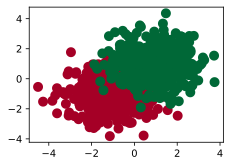

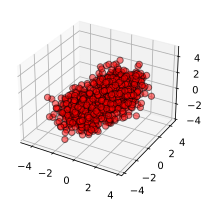

In [25]:
# Generate the data
# since it is a classfication task, we need generate fake data from two distributions
num_examples = 10000
num_features = 3
x_0 = torch.tensor(np.random.normal(-1,1,size=(500,num_features)),dtype=torch.float32)
y_0 = torch.zeros(500)
x_1 = torch.tensor(np.random.normal(1,1,size=(500,num_features)),dtype=torch.float32)
y_1 = torch.ones(500)
#print(x_0)
#print(x_1)
features = torch.cat((x_0,x_1),0)
labels = torch.cat((y_0,y_1),0)
print(features.size(),labels.size())
#print(labels)


# Visualize the data distribution
def visualize_data_2d(features, labels):
    d2dl.use_svg_display()
    d2dl.set_figsize()
    #plt.scatter(features[:,dim],labels,1)
    plt.scatter(features.data.numpy()[:,0], features.data.numpy()[:,1], c=labels.data.numpy(), s=100, lw=0, cmap='RdYlGn')

def visualize_data_3d(features, labels):
    d2dl.use_svg_display()
    d2dl.set_figsize()
    ax = Axes3D(plt.figure())
    NumP = 50
    x = features.data.numpy()[:,0]
    y = features.data.numpy()[:,1]
    z = features.data.numpy()[:,2]
    ax.scatter(x,y,z,s=40,c='r',edgecolor='k',alpha=0.5)

visualize_data_2d(features, labels)
visualize_data_3d(features, labels)

60000


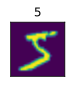

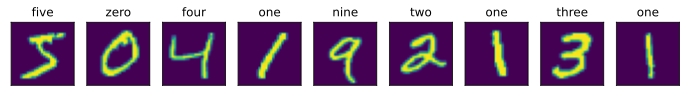

In [26]:
# Obtain Data
train_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',train=True,\
                                        download=False,transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',train=False,\
                                        download=False,transform=transforms.ToTensor())
print(len(train_data))
#print(train_data[0])

# Load Data
train_data_iterator = Data.DataLoader(train_data,batch_size)
test_data_iterator = Data.DataLoader(test_data,batch_size)

# Visualization of MNIST data
def show_image(img, label):
    d2dl.use_svg_display() 
    plt.figure(figsize=(1, 1))
    plt.imshow(img.view(img.size(1),img.size(1),-1).numpy())
    plt.title(label)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.plot()

def get_label_name(labels):
    text_labels = ['zero', 'one', 'two', 'three', 'four',
                   'five', 'six', 'seven', 'eight', 'nine']
    return [text_labels[int(i)] for i in labels]

def show_multiple_image(images, labels):
    d2dl.use_svg_display() 
    _,figs = plt.subplots(1,len(images),figsize=(12,12))  # figure,axes=plt.subplots(), each axes can represent a subplot
    for fig,image,label in zip(figs,images,labels):
        fig.imshow(image.view(image.size(1),image.size(1),-1).numpy())
        fig.set_title(label)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

# get data
image_exmp, label_exmp = train_data[0]
image_batch, label_batch = iter(train_data_iterator).next()

# show one images
show_image(image_exmp,label_exmp)

# can either use dataloader or datasets.MNIST to do visualization
#X,y = [], []
#for i in range(10):
#    X.append(train_data[i][0])
#    y.append(train_data[i][1])
#show_multiple_image(X,get_labels(y))

# show multiple images
show_multiple_image(image_batch[0:9],get_label_name(label_batch[0:9]))